In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
import string
from joblib import dump, load
from datetime import date
import itertools 
import scipy 


In [2]:
n_conditions = 5 # Number of ligand conditions aka times (t1, t2, t3, ..., tn) 
n_macrostates = 5 # Number of Macro states 
n_executions = 20 # Clustering repetition
n_microstates = 100 # To comply with n_microstates = n_states * n_executions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sys_name = 'toyModel_continuum_'

In [3]:
def Covariance_matrix(sigma_x, sigma_y):
    covariance = [sigma_x, sigma_y]  # Covariance matrix
    # Calculate the eigenvalues
    eigenvalues, _ = np.linalg.eig(covariance)
    
    # Check if all eigenvalues are non-negative
    positive_semidefinite = np.all(eigenvalues >= 0)
    if positive_semidefinite:
       print("Eigenvalues of Covariance matrix:", eigenvalues)
       print("Is the covariance matrix positive semidefinite?", positive_semidefinite)
    else:
       print("Is the covariance matrix positive semidefinite?", positive_semidefinite)
       sys.exit(0) 
    return covariance 

In [4]:
def mean_2d(x, y):
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    mean = [mu_x, mu_y]
    
    return mean

In [5]:
# Calculate a Gaussian distribution with a given mean and variance 
def Gaussian_distribution(mean, covariance, positions):

    # Calculate the Gaussian distribution on the grid
    Gaussian = np.exp(-0.5 * (np.einsum('...k,kl,...l->...',
                                     positions-mean, np.linalg.inv(covariance), positions-mean)))
    Gaussian /= 2.0 * np.pi * np.sqrt(np.linalg.det(covariance))
    
    return Gaussian

In [6]:
sigma_x = [4.15, 1.56]
sigma_y = [2.53, 3.78]
covariance = Covariance_matrix(sigma_x, sigma_y) # Covariance matrix
covariance = np.array(covariance)

x_start, x_end, x_step = -25, 25, 0.05
y_start, y_end, y_step = -25, 25, 0.05

# Create the Mesh grid
x, y = np.mgrid[x_start:x_end:x_step, y_start:y_end:y_step]

# Generate grid points
positions = np.empty(x.shape + (2, ))
positions[:, :, 0] = x
positions[:, :, 1] = y

x_vec = np.arange(x_start, x_end, x_step)
y_vec = np.arange(y_start, y_end, y_step)

means = [[5.0, 7.0], [13.0, 15.0], [-18.0, -20.0], [-10.0, -5.0]]
scale_factors = [[1.3, 1.1, 1.4, 1.2], 
                 [0.9, 0.8, 1.8, 1.5], 
                 [1.1, 0.7, 0.5, 1.4],
                 [1.5, 1.6, 1.35, 1.3], 
                 [1.2, 1.35, 0.9, 1.1]]
means = np.array(means)
scale_factors = np.array(scale_factors)
nGauss = 4
nGauss = int(nGauss)

covariance_gauss = []
for i in range(nGauss): 
    # Create a variation of the base covariance matrix
    scale_factor = np.random.uniform(0.5, 1.5)  # Scale factor between 0.5 and 1.5 for variation
    covariance_variation = np.random.uniform(0.9, 1.1, size=(2, 2))  # Slight random perturbation
    covariance_loc = covariance * scale_factor * covariance_variation

    # Ensure covariance_loc remains symmetric and positive semidefinite
    covariance_loc = (covariance_loc + covariance_loc.T) / 2.0
    covariance_gauss.append(covariance_loc)

covariance_mGauss = np.array(covariance_gauss)
Gaussians = []

for i in range(n_conditions):
    mix_Gaussians = 0.0
    for j in range(nGauss):
        Gauss_dist = Gaussian_distribution(means[j], covariance_mGauss[j], positions)
        Gauss_dist = Gauss_dist*scale_factors[i][j]
        mix_Gaussians += Gauss_dist
    Gaussians.append(mix_Gaussians)
Gaussians = np.array(Gaussians)

Eigenvalues of Covariance matrix: [5.96025061 1.96974939]
Is the covariance matrix positive semidefinite? True


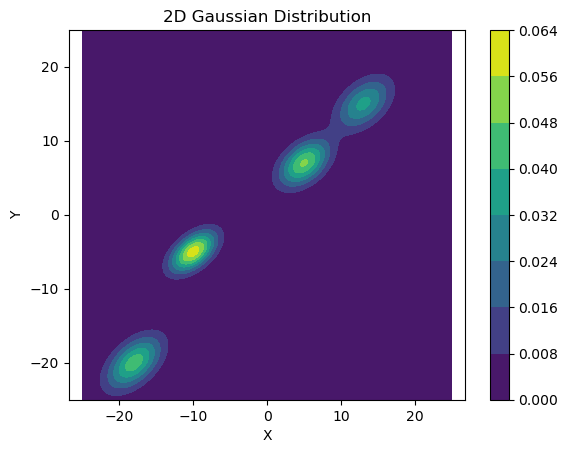

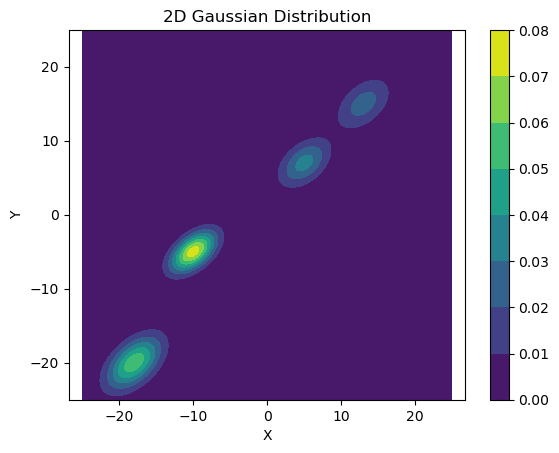

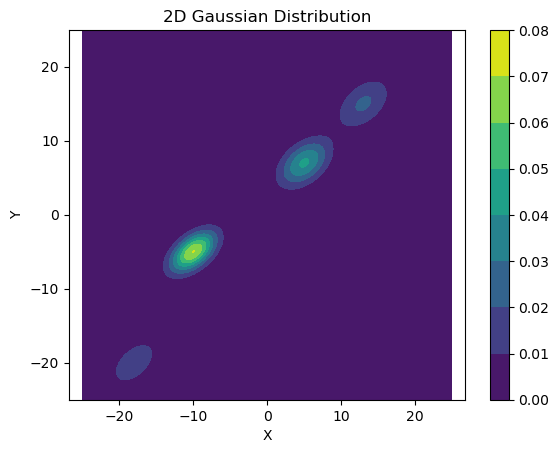

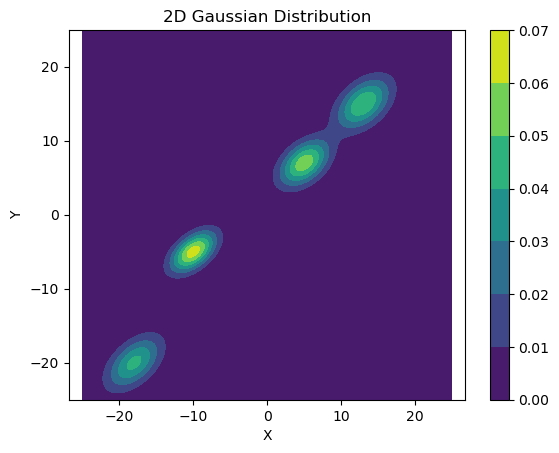

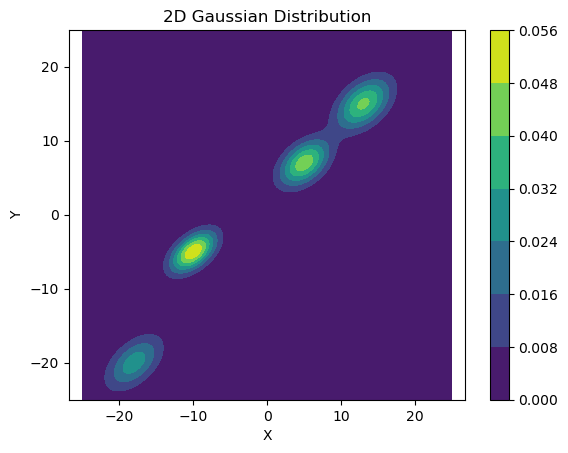

In [7]:
# Plotting
for i in range(n_conditions):
    plt.contourf(x, y, Gaussians[i])
    plt.colorbar()
    plt.title('2D Gaussian Distribution')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.pause(0.33)
    #plt.show()

In [8]:
# Compute Gaussian distribution at multiple positions
def microstate_RNA_levels_multGauss(sigma_x, sigma_y, n_Gaussians):
    
    x_start, x_end, x_step = -0.5, 0.5, 0.1
    y_start, y_end, y_step = -0.5, 0.5, 0.1

    # Create the Mesh grid
    x, y = np.mgrid[x_start:x_end:x_step, y_start:y_end:y_step]

    # Generate grid points
    positions = np.empty(x.shape + (2, ))
    positions[:, :, 0] = x
    positions[:, :, 1] = y
    
    # Initialize the mixture distribution
    mixture = np.zeros(x.shape)

    covariance = Covariance_matrix(sigma_x, sigma_y)
    # Base covariance matrix
    base_covariance = np.array(covariance)

    # Define parameters for n_Gaussians different Gaussians
    for i in range(n_Gaussians):
        mean_loc = [np.random.uniform(x_start, x_end), np.random.uniform(y_start, y_end)]
        
        # Create a variation of the base covariance matrix
        scale_factor = np.random.uniform(0.5, 1.5)  # Scale factor between 0.5 and 1.5 for variation
        covariance_variation = np.random.uniform(0.9, 1.1, size=(2, 2))  # Slight random perturbation
        covariance_loc = base_covariance * scale_factor * covariance_variation

        # Ensure covariance_loc remains symmetric and positive semidefinite
        covariance_loc = (covariance_loc + covariance_loc.T) / 2.0
        
        # Compute the Gaussian distribution for each Gaussian and add it to the mixture
        mixture += Gaussian_distribution(np.array(mean_loc), covariance_loc, positions)

    return x, y, mixture


In [9]:
# Generate RNA level data to mimic the experiments by convoluting multiple Gaussians
n_Gaussians = 5
sigma_x = [0.28, 0.16]; sigma_y = [0.14, 0.25]
x_rna, y_rna, mGaussRNAlevels = microstate_RNA_levels_multGauss(sigma_x, sigma_y, n_Gaussians)
print(mGaussRNAlevels.shape)

Eigenvalues of Covariance matrix: [0.41541609 0.11458391]
Is the covariance matrix positive semidefinite? True
(10, 10)


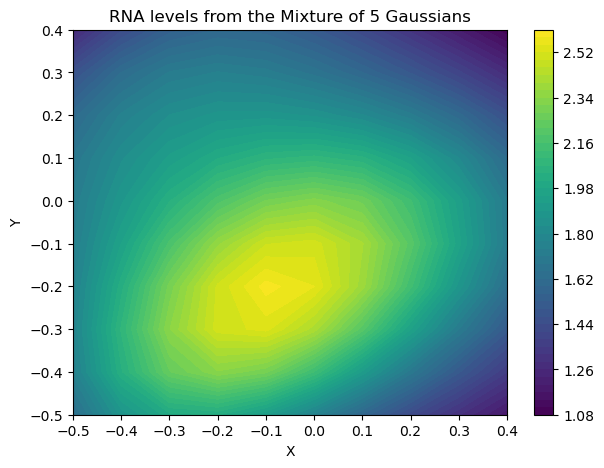

In [10]:
# Plotting
plt.figure(figsize = (7, 5))
plt.contourf(x_rna, y_rna, mGaussRNAlevels, levels = 50, cmap = 'viridis')
plt.colorbar()
plt.title(f'RNA levels from the Mixture of {n_Gaussians} Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [92]:
# Reshape the pos array into two dimensions
pos_reshaped = positions.reshape(-1, 2)

##### Cluster single-cell trajectories of a given snippet length by using KMeans from deeptime 
from deeptime.clustering import KMeans
model = KMeans(n_clusters = n_microstates,  # place 100 cluster centers
               init_strategy = 'kmeans++',  # kmeans++ initialization strategy
               max_iter = 0,
               fixed_seed = 13)  # don't actually perform the optimization, just place centers
               
################################ Initial clustering ###############################
clustering = model.fit(pos_reshaped).fetch_model()  

model.initial_centers = clustering.cluster_centers
model.max_iter = 5000
clusters = model.fit(pos_reshaped).fetch_model()  


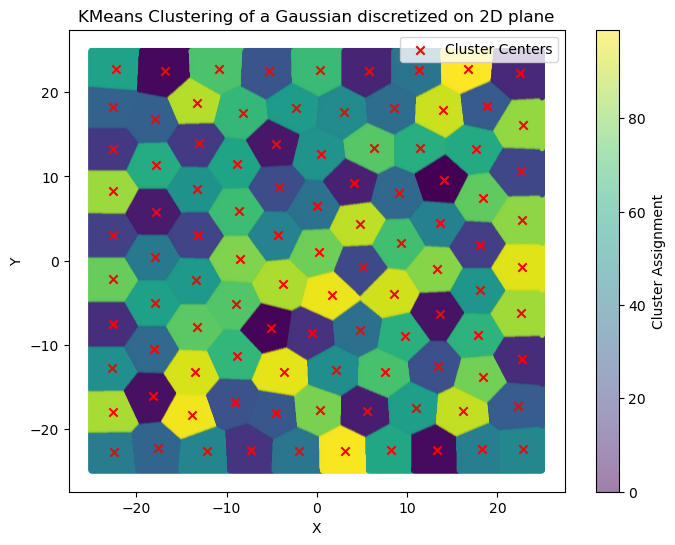

In [93]:
from scipy.spatial.distance import cdist
# Extract cluster assignments and centers
cluster_centers = clusters.cluster_centers
# Assign each point to the nearest cluster center
distances = cdist(pos_reshaped, cluster_centers, 'euclidean')
cluster_assignments = np.argmin(distances, axis=1)

# Reshaped plotting
x_plot, y_plot = pos_reshaped[:, 0], pos_reshaped[:, 1]

# Plotting
plt.figure(figsize=(8, 6))
scatter_plot = plt.scatter(x_plot, y_plot, c=cluster_assignments, cmap='viridis', alpha=0.5, marker='.')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.title(f'KMeans Clustering of a Gaussian discretized on 2D plane')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc = 'upper right')
# Adding a colorbar
plt.colorbar(scatter_plot, label='Cluster Assignment')
plt.show()


In [37]:
# Initialize an array for average densities
n_clusters = cluster_centers.shape[0]
average_densities = np.zeros((n_conditions, n_clusters))

for ig in range(n_conditions): # Different time points or conditions 
    # Flatten Gaussians to match the shape of pos_reshaped
    Gauss_dist_flattened = Gaussians[ig].reshape(-1)

    # Calculate the average density for each cluster
    for i in range(n_clusters):
        indices = np.where(cluster_assignments == i)[0]
        if len(indices) > 0:  # Ensure there are points assigned to the cluster
            # Calculate average density (Gaussian values) corresponding to each cluster center 
            average_densities[ig][i] = np.nansum(Gauss_dist_flattened[indices])  


In [38]:
# Normalize probability densities 
normalized_densities = np.zeros_like(average_densities)

for ig in range(n_conditions):
    total_density = np.sum(average_densities[ig])
    if total_density > 0:
        normalized_densities[ig] = average_densities[ig] / total_density
microstate_probability_t = normalized_densities


In [40]:
from scipy.spatial import distance_matrix
from sklearn.metrics import adjusted_rand_score

def custom_clustering(clustering_features, initial_points):
    # Calculate the distance from each point in vkin to each initial point (centroid)
    dists = distance_matrix(clustering_features, initial_points)
    
    # Assign each point to the nearest centroid
    nearest_centroid_indices = np.argmin(dists, axis=1)
    
    return nearest_centroid_indices

def unique_multi_iterative_clustering(clustering_features, n_clusters,
                                      n_iterations=10, n_executions=10, ari_threshold=1.0):
    accepted_clusterings = []
    execution = 0
    while len(accepted_clusterings) < n_executions:
        # Re-initialize centroids (Macro cluster centers) randomly for each execution
        np.random.seed(execution)  # Different seed for each execution
        # Re-initialize centroids randomly
        initial_points = clustering_features[np.random.choice(np.arange(len(clustering_features)),
                                                              size=n_clusters, replace=False), :]
        
        for _ in range(n_iterations):
            # Assign clusters and update centroids
            cluster_assignments = custom_clustering(clustering_features, initial_points)
            for i in range(n_clusters):
                points_in_cluster = clustering_features[cluster_assignments == i]
                if points_in_cluster.size > 0:
                    initial_points[i] = np.mean(points_in_cluster, axis=0)

        # Check the new clustering against all accepted clusterings for uniqueness
        is_unique = True
        for previous_assignments in accepted_clusterings:
            ari_score = adjusted_rand_score(cluster_assignments, previous_assignments)
            if ari_score > ari_threshold:
                is_unique = False
                break  # The new clustering is too similar to a previous one, discard it

        if is_unique:
            accepted_clusterings.append(cluster_assignments)  # Accept the new clustering
        execution += 1
            
    return accepted_clusterings


In [42]:
# Cluster multiple times and check if the states are unique  
macro_clusters = unique_multi_iterative_clustering(cluster_centers, n_macrostates,
                                                  n_iterations = 10,
                                                  n_executions = n_executions)


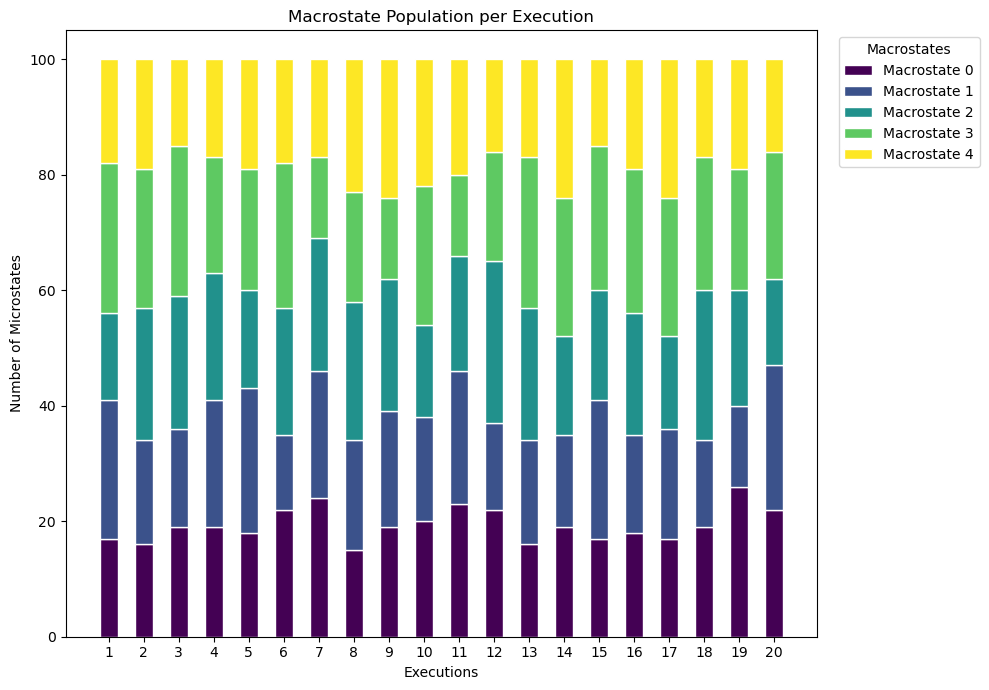

In [43]:
# Initialize a matrix to hold the count of microstates for each macrostate in each execution
cluster_populations_visual = np.zeros((n_executions, n_macrostates))

# Count microstates for each macrostate in each execution
for execution, assignments_visual in enumerate(macro_clusters):
    cluster_counts_visual = np.bincount(assignments_visual, minlength=n_macrostates)
    cluster_populations_visual[execution, :] = cluster_counts_visual

# Colors for each macrostate
colors = plt.cm.viridis(np.linspace(0, 1, n_macrostates))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# Creating the stacked bar chart
for i in range(n_macrostates):
    # Extracting the population for macrostate i across all executions
    macrostate_population_visual = cluster_populations_visual[:, i]
    
    # Bottom parameter for the bar plot, to stack the macrostates
    if i == 0:
        bottoms = np.zeros(n_executions)
    else:
        bottoms += cluster_populations_visual[:, i-1]
    
    ax.bar(range(n_executions), macrostate_population_visual, bottom=bottoms,
           color=colors[i], edgecolor='white', width=0.5, label=f'Macrostate {i}')

ax.set_xlabel('Executions')
ax.set_ylabel('Number of Microstates')
ax.set_title('Macrostate Population per Execution')
ax.set_xticks(range(n_executions))
ax.set_xticklabels([f'{i+1}' for i in range(n_executions)])
ax.legend(title="Macrostates", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

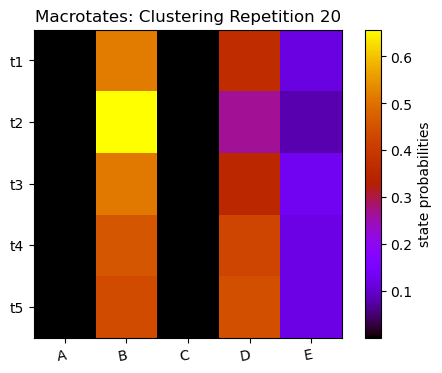

In [44]:
from IPython.display import clear_output
t_sets = ['t1', 't2', 't3', 't4', 't5']
t_sets = np.array(t_sets)
state_labels = np.array(list(string.ascii_uppercase))[0:n_macrostates]
state_order = np.arange(n_macrostates).astype(int)
cluster_macrostate_probs = [] # Macrostate probabilities of all cluster repetitions 
for iEx in range(n_executions):
    macrostate_probs = np.zeros((n_conditions, n_macrostates))
    # Get transition probability distribution at different times 
    for time_idx in range(n_conditions):
        # Aggregate distribution_t into macrostate probabilities
        for microstate_idx in range(n_microstates):
             macrostate = macro_clusters[iEx][microstate_idx] # Find the macrostate for this cluster
             # Aggregate probabilities that belong to the respective macro cluster
             macrostate_probs[time_idx, macrostate] += microstate_probability_t[time_idx][microstate_idx]   
    
    cluster_macrostate_probs.append(macrostate_probs)
    clear_output(wait = True)
    plt.clf()
    plt.figure(figsize = (6, 4))
    plt.imshow(macrostate_probs[:, state_order], cmap=plt.cm.gnuplot)
    cbar = plt.colorbar()
    cbar.set_label('state probabilities')
    # We want to show all ticks...
    ax = plt.gca()
    ax.set_yticks(np.arange(n_conditions))
    ax.set_xticks(np.arange(n_macrostates))
    ax.set_xticklabels(np.array(state_labels)[state_order])
    ax.set_title(f'Macrotates: Clustering Repetition {iEx+1}')
    ax.set_yticklabels(t_sets)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=10, ha="right",rotation_mode="anchor")
    plt.pause(.33);


In [45]:
def bulk_rna_levels(probability_distribution_t, microstate_rna_levels, n_conditions):

    bulk_rna = []
    
    for time_ind in range(n_conditions):
        bulk_rna_local = 0.
        for microstate_ind in range(n_microstates):  
            prob = probability_distribution_t[time_ind][microstate_ind]
            bulk_rna_local += prob*microstate_rna_levels[microstate_ind]
        bulk_rna.append(bulk_rna_local)
    
    bulk_rna = np.array(bulk_rna)    
    return bulk_rna

# RNA levels generated by using multiple Gaussians for "n_microstates"
microstate_rna_levels = mGaussRNAlevels.reshape(-1, 1) 
# Calculate bulk RNA levels 
bulk_rna_levels = bulk_rna_levels(microstate_probability_t, microstate_rna_levels, n_conditions)

In [62]:
def get_macrostate_decomposition(x_fc, state_probs, ncombinations=500,
                                 save_file=None, visual=False,
                                 verbose=True, nchunk=100):
    nStates = state_probs.shape[1] # number of morphodynamic (Macro) states
    n_conds = state_probs.shape[0] # set conditions
    #nGenes = x_fc.shape[1]
    
    lb = np.zeros(nStates)
    ub = np.ones(nStates)*np.inf
    measured_rna_synd = x_fc.shape[0] # fold-change values of RNA levels for "n_microstates"
    
    x_fc_states = np.ones((nStates))*np.nan
    inds_conds = np.arange(n_conds).astype(int)
    comb_trainarray = np.array(list(itertools.combinations(inds_conds, nStates)))
    ncomb = comb_trainarray.shape[0]
    print(f'{ncomb} possible combinations of {n_conds} measurements decomposed into {nStates} states')
    if ncombinations > ncomb:
        ncombinations = ncomb
    print(f'using {ncombinations} of {ncomb} possible combinations randomly per feature')
    # Generate a uniform random sequence from np.arange(ncomb) of size "ncombinations"
    indr = np.random.choice(ncomb, ncombinations, replace=False)
        
    if save_file is not None:
        np.save(save_file, x_fc_states)
    v_states_comb = np.zeros((ncombinations, nStates))
    for icomb in range(ncombinations):
        indcomb = comb_trainarray[indr[icomb]] # Pick randomized index to remove bias 
        v_treatments = x_fc[indcomb, 0] # Pick a ligand condition randomly and use its RNA levels
        # Least square linear optimization for each Gene --> solving state_probs*x = v_treatments (fold-change)  
        res = scipy.optimize.lsq_linear(state_probs[indcomb, :], v_treatments, bounds=(lb, ub), verbose=1)
        v_states_comb[icomb, :] = res.x.copy() # x (contribution of each state) is returned from scipy.optimize.lsq_linear 
    v_states = np.mean(v_states_comb, axis=0)
    x_fc_states = v_states.copy() # log-fold change of a selected gene across morphodynamic states
    
    if save_file is not None:
        np.save(save_file, x_fc_states)
    return x_fc_states


In [74]:
 # Cluster RNA levels by repetition of clustering multiple times 
x_fc_states_exec = np.zeros((n_executions, n_macrostates))
prob_macrostates_cluster = np.zeros((n_microstates, n_microstates))
visual = False
state_count = 0
# Calculate Gene levels 
for ind_ex in range(n_executions):
    
        state_probs = cluster_macrostate_probs[ind_ex]
        state_probs = np.array(state_probs)
        #print(state_probs)
        
        get_counts = True
        if get_counts:
            x_fc_states = get_macrostate_decomposition(bulk_rna_levels, state_probs, ncombinations=500, 
                                                  save_file=None, visual=visual)
        else:
            x_fc_states = np.load('macrostates_foldchange_'+figid+'.npy')
             
        x_fc_states_exec[ind_ex] = x_fc_states
        #print(x_fc_states)
        
        # Get transition probability corresponding to microstates & times 
        for time_indx in range(n_conditions):
             # Aggregate distribution_t into macrostate probabilities
             indices = np.where(macro_clusters[iEx] == time_indx)[0]
             indc_macro = time_indx + state_count
             if len(indices) > 0:
                for inds_micro in indices:
                    prob_macrostates_cluster[indc_macro][inds_micro] = microstate_probability_t[time_indx][inds_micro]
        state_count += int(n_macrostates)


1 possible combinations of 5 measurements decomposed into 5 states
using 1 of 1 possible combinations randomly per feature
The first-order optimality measure is less than `tol`.
Number of iterations 14, initial cost 3.0368e+01, final cost 1.2572e-05, first-order optimality 2.95e-16.
1 possible combinations of 5 measurements decomposed into 5 states
using 1 of 1 possible combinations randomly per feature
The first-order optimality measure is less than `tol`.
Number of iterations 8, initial cost 6.4671e-02, final cost 4.1814e-05, first-order optimality 5.62e-12.
1 possible combinations of 5 measurements decomposed into 5 states
using 1 of 1 possible combinations randomly per feature
The first-order optimality measure is less than `tol`.
Number of iterations 3, initial cost 1.2025e-09, final cost 1.6901e-18, first-order optimality 6.96e-12.
1 possible combinations of 5 measurements decomposed into 5 states
using 1 of 1 possible combinations randomly per feature
The first-order optimality 

In [75]:
# Normalize probability densities 
norm_prob_macro_cluster = np.zeros_like(prob_macrostates_cluster)

for ig in range(n_microstates):
    total_density = np.sum(prob_macrostates_cluster[ig])
    if total_density > 0:
        norm_prob_macro_cluster[ig] = prob_macrostates_cluster[ig] / total_density

In [82]:
####### Calculate microstate RNA levels from the cluster RNA levels ####### 
b = np.array(x_fc_states_exec.reshape(-1, 1))
A = np.array(norm_prob_macro_cluster)
# Solve for b = A*x, where 'x' is the microstate RNA levels 
microstate_rna_levels_pred, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
#print(microstate_rna_levels_pred)

In [87]:
x_pred = microstate_rna_levels_pred  # Solution from lstsq
b_pred = np.dot(A, x_pred)
manual_residuals = b - b_pred
manual_residual_norm = np.linalg.norm(manual_residuals)
print("Manual residual norm:", manual_residual_norm)

Manual residual norm: 38310916206.559814


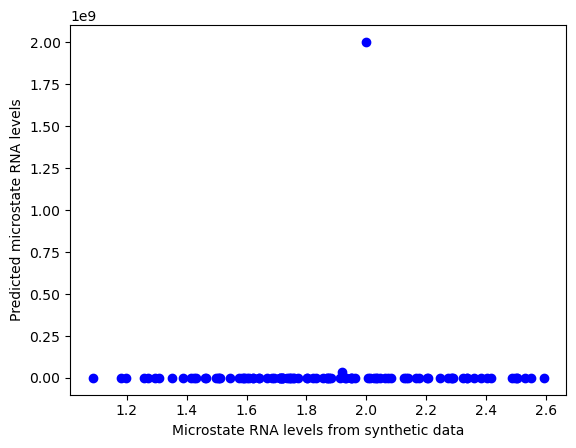

In [78]:
plt.scatter(microstate_rna_levels, microstate_rna_levels_pred, color='b', marker='o')
plt.xlabel('Microstate RNA levels from synthetic data')
plt.ylabel('Predicted microstate RNA levels')
plt.show()